### HARSHITA MAHESH HIREMATH

In [1]:
import pandas as pd
import numpy as np

from sklearn import tree
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import export_graphviz
import graphviz

import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('Titanic.csv')
data.head()

,Unnamed: 0,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1st,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.337494,B5,Southampton,2,NaN,"St Louis, MO"
1,2,1st,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.550003,C22 C26,Southampton,11,NaN,"Montreal, PQ / Chesterville, ON"
2,3,1st,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.550003,C22 C26,Southampton,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,4,1st,0,"Allison, Mr. Hudson Joshua Crei",male,30.0000,1,2,113781,151.550003,C22 C26,Southampton,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,5,1st,0,"Allison, Mrs. Hudson J C (Bessi",female,25.0000,1,2,113781,151.550003,C22 C26,Southampton,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [3]:
# Define the features (X) and the target (y)
X = data.drop(columns=["survived"])  # Features (excluding the "Survived" column)
y = data["survived"]  # Target variable

# Preprocess the data
data = data.drop(data.columns[0],axis=1)
data['sex'] = LabelEncoder().fit_transform(data['sex'])  # Encode 'sex' as 0 or 1
data.fillna({'age': data['age'].mean()}, inplace=True)  # Fill missing values in 'age' with the mean

# One-hot encode the 'pclass' column
pclass_encoder = OneHotEncoder()
pclass_encoded = pclass_encoder.fit_transform(data['pclass'].values.reshape(-1, 1)).toarray()
pclass_encoded_df = pd.DataFrame(pclass_encoded, columns=pclass_encoder.get_feature_names_out(['pclass']))
data = pd.concat([data, pclass_encoded_df], axis=1)

# Select the independent variables and dependent variable
X = data[['sex', 'age', 'sibsp'] + list(pclass_encoded_df.columns)]
y = data['survived']

# Split the data into training (70%) and test (30%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [4]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X, y)  # Fit the model with data

# Export the decision tree to Graphviz format
dot_data = export_graphviz(
    decision_tree,
    out_file=None,  # Setting this to None will return the dot data as a string
    filled=True,  # Fill the boxes with colors
    feature_names=X.columns,  # Feature names
    class_names=["No", "Yes"],  # Class labels
    special_characters=True,
)

# Create a Graphviz object from the dot data
graph = graphviz.Source(dot_data)

# Render the tree to a file or display it
graph.render("decision_tree")  # Save to a file
graph.view("decision_tree")  # View the tree

'decision_tree.pdf'

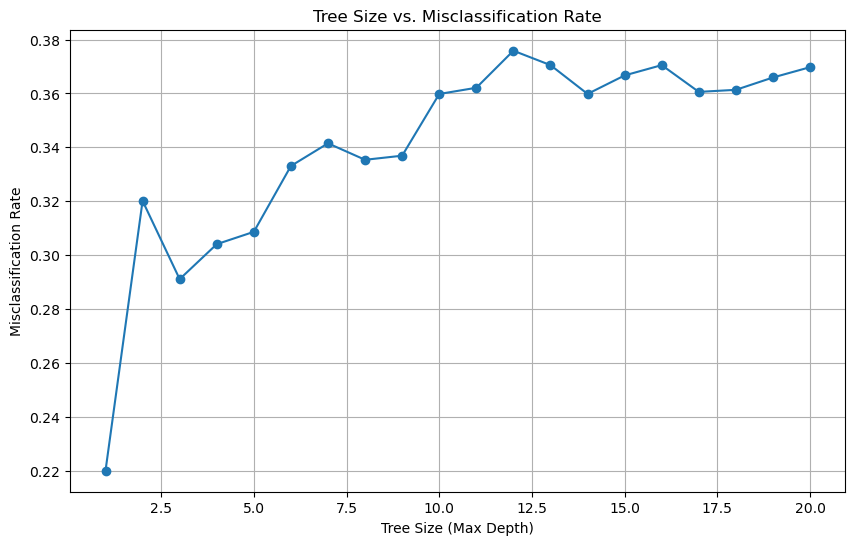

Best tree size (max_depth): 1


DecisionTreeClassifier(max_depth=1)

In [5]:
param_grid = {'max_depth': list(range(1, 21))}

#Use GridSearchCV for cross-validation and parameter tuning
grid_search = GridSearchCV(decision_tree, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X, y)

# Extract results and plot the graph
results = grid_search.cv_results_

# Extract tree sizes and misclassification rates
tree_sizes = results['param_max_depth']
misclassification_rates = 1 - results['mean_test_score']

# Plot the graph
plt.figure(figsize=(10, 6))
plt.plot(tree_sizes, misclassification_rates, marker='o')
plt.title('Tree Size vs. Misclassification Rate')
plt.xlabel('Tree Size (Max Depth)')
plt.ylabel('Misclassification Rate')
plt.grid(True)
plt.show()

# Find the best parameter (optimal tree size)
best_tree_size = grid_search.best_params_['max_depth']
print(f"Best tree size (max_depth): {best_tree_size}")

# Train a decision tree with the best parameter
optimal_decision_tree = DecisionTreeClassifier(max_depth=best_tree_size)
optimal_decision_tree.fit(X, y)

Optimal Tree Size (max_depth): 1
Accuracy on test set (survivors): 67.46%
Accuracy on test set (fatalities): 87.50%


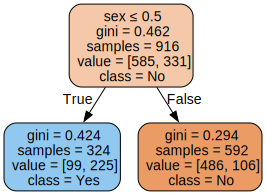

In [6]:
# Find the optimal tree size that minimizes misclassifications
optimal_tree_size = tree_sizes[np.argmin(misclassification_rates)]

# Train a decision tree with the optimal tree size
optimal_decision_tree = DecisionTreeClassifier(max_depth=optimal_tree_size)
optimal_decision_tree.fit(X_train, y_train)

# Report accuracy on the test set for the pruned tree
y_test_pred = optimal_decision_tree.predict(X_test)

# Calculate accuracy for survivors and fatalities
survivors_correct = sum((y_test == 1) & (y_test_pred == 1))
fatalities_correct = sum((y_test == 0) & (y_test_pred == 0))
total_survivors = sum(y_test == 1)
total_fatalities = sum(y_test == 0)

accuracy_survivors = (survivors_correct / total_survivors) * 100
accuracy_fatalities = (fatalities_correct / total_fatalities) * 100

print(f"Optimal Tree Size (max_depth): {optimal_tree_size}")
print(f"Accuracy on test set (survivors): {accuracy_survivors:.2f}%")
print(f"Accuracy on test set (fatalities): {accuracy_fatalities:.2f}%")

# Plot the pruned decision tree
dot_data = export_graphviz(optimal_decision_tree, out_file=None, 
                           feature_names=X.columns, class_names=["No", "Yes"],
                           filled=True, rounded=True, special_characters=True)

# Render the tree using Graphviz
graph = graphviz.Source(dot_data)
graph.render("pruned_decision_tree")  # This will save the tree as 'pruned_decision_tree.pdf'

# Display the tree in Jupyter Notebook or IPython
graph

In [7]:
random_forest = RandomForestClassifier(n_estimators=50, max_depth=optimal_tree_size, random_state=42)
random_forest.fit(X_train, y_train)

# Predict on the test set
y_rf_test_pred = random_forest.predict(X_test)

# Calculate accuracy for survivors and fatalities
survivors_correct = sum((y_test == 1) & (y_rf_test_pred == 1))
fatalities_correct = sum((y_test == 0) & (y_rf_test_pred == 0))
total_survivors = sum(y_test == 1)
total_fatalities = sum(y_test == 0)

accuracy_rf_survivors = (survivors_correct / total_survivors) * 100
accuracy_rf_fatalities = (fatalities_correct / total_fatalities) * 100

print(f"Accuracy of Random Forest on test set (survivors): {accuracy_rf_survivors:.2f}%")
print(f"Accuracy of Random Forest on test set (fatalities): {accuracy_rf_fatalities:.2f}%")

Accuracy of Random Forest on test set (survivors): 26.63%
Accuracy of Random Forest on test set (fatalities): 99.55%


Potential reasons for the observed differences in performance:

- **Complexity**: Random Forests are typically more complex, and this complexity might not be necessary for the dataset. A well-pruned single decision tree could be sufficient.

- **Dataset Size**: If the dataset is relatively small, a single well-pruned decision tree might perform as well or better than a Random Forest.

- **Imbalanced Data**: The data might be imbalanced, and Random Forests can struggle with imbalanced datasets. The well-pruned decision tree might handle the imbalance better.

- **Model Tuning**: The Random Forest might benefit from further hyperparameter tuning, such as adjusting the number of trees and tree depth.

- **Feature Importance**: The importance of features can vary between a single decision tree and a Random Forest, contributing to the difference in performance.

The choice between a single decision tree and a Random Forest depends on the specific dataset characteristics and problem, as well as model tuning and feature engineering. 